#CIS 545 G21 Final Project
- G21: Seungmin Han, Alex Park, Sebin Lee
- TA: Bhairavi Muralidharan

#Project Introduction
> For our final project, our team created predicted titles of academic papers based on their abstracts and identified the trending keywords in each academic area. Then we made a neural network model to predict the classification of the papers into research categories that we developed during the data cleaning step based on the titles that we generated through prediction. We used the arXiv dataset from Kaggle (https://www.kaggle.com/datasets/Cornell-University/arxiv) to get data of 2M+ papers.

>Our cleaned dataset exported as .csv file can be accessed through this google drive link (https://drive.google.com/drive/folders/19Sxv6L7bqH6UwHNYjPD3UO28z7fqxtbC?usp=share_link)

> We approached the dataset with a hypothesis that there will be a set of significantly repetitive words in each research category when analyzing the titles and abstracts. Based on this initial assumption, our ultimate goal is to gain insights in trends of different research areas and to build a prediction model from the abstract to the title, and from the title to the research area.  

> Our project can be divided into the following 4 sections.

1. Clustering of Academic Papers into different research area/topics
2. WordClouds showing the research trend in each area
3. Using SimpleT5 Model to generate title from the abstract of research papers 
4. Using RNN to predict research area from the generated titles from Section 3



# Import the Required Libraries

In [ ]:
!pip install simplet5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 27.7 MB/s 
     |████████████████████████████████| 3.5 MB 66.2 MB/s 
     |████████████████████████████████| 527 kB 92.2 MB/s 
     |████████████████████████████████| 952 kB 72.5 MB/s 
     |████████████████████████████████| 512 kB 95.7 MB/s 
     |████████████████████████████████| 829 kB 89.8 MB/s 
     |████████████████████████████████| 7.6 MB 77.0 MB/s 
     |████████████████████████████████| 880 kB 76.0 MB/s 
     |████████████████████████████████| 182 kB 74.0 MB/s 
  Created wheel for simplet5: filename=simplet5-0.1.4-py3-none-any.whl size=6873 sha256=41829f4df7d37baf5ffb0795d513e76a576351392fbbf58083149743293bdb0f
  Stored in directory: /root/.cache/pip/wheels/32/a6/37/e007cfdbceac6347aa13bc2a881ac87d2a3d6e4202663ee311
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=47034e78eeffcac5329bdf8578fba3dd

In [ ]:
from simplet5 import SimpleT5
import pandas as pd
import numpy as np
import json as json
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split

import re

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


#Section 1. Data Collection, Wrangling, Cleaning
> 1. Importing dataset from Kaggle
2. Clean the data
3. Split into smaller dataframes by their categories

**1.Importing Dataset From Kaggle**

> We imported the data directly from kaggle as we have done in our homeworks and stored the cleaned csv files in the mounted google drive.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle datasets download -d Cornell-University/arxiv -p /content/kaggle/

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 1.10G/1.10G [00:57<00:00, 26.8MB/s]
100% 1.10G/1.10G [00:57<00:00, 20.7MB/s]


In [ ]:
!unzip /content/kaggle/arxiv.zip

Archive:  /content/kaggle/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


> Some of the challenges we faced include the sheer size of the data set; we kept crashing mid-runtime. Just reading the file took multiple attempts. So we stored the dataframe a separate csv file in our drives. 
We first checked the missing values. We cleaned the data by dropping unnecessary columns and running dropna on the remaining columns: id, title, journal-ref, categories, doi, abstract. 
Then split the metadata_df into dataframes for each research area and tried running simpleT5. But because of the size of the dataset (physics_df alone was 600k+) we could not train the model.

> **So we bought Colab Pro :)**


In [ ]:
from transformers.utils.dummy_tf_objects import TFDPRQuestionEncoder
file = '/content/arxiv-metadata-oai-snapshot.json'

#metadata_df = pd.read_json(file, lines = True)
metadata_df = pd.DataFrame()
list_train = []
counter = 0
for line in open(file, 'r'):
  list_train.append(json.loads(line))
  if counter == 700000:
    metadata_df = pd.concat([metadata_df, pd.DataFrame.from_dict(list_train)])
    list_train = []
    counter = 0
    continue
  counter += 1
if counter > 0:
  metadata_df = pd.concat([metadata_df, pd.DataFrame.from_dict(list_train)])

**2. Clean the data**

> We dropped the rows with missing values in id, title, journal-ref, doi, categories, and abstract column as we considered papers missing such information as lacking credibility.

In [ ]:
metadata_df = metadata_df[["id", "title", "journal-ref", "doi", "categories", "abstract"]].dropna()
metacopy = metadata_df.copy()

In [ ]:
metadata_df.sample(10)

,id,title,journal-ref,doi,categories,abstract
40957,0712.3036,Quenched mesonic spectrum at large N,"JHEP 0803:062,2008",10.1088/1126-6708/2008/03/062,hep-th hep-lat hep-ph,We compute the masses of the $\pi$ and of th...
560895,2003.10541,Physical realization of complex dynamical patt...,New J. Phys. 24 (2022) 033018,10.1088/1367-2630/ac47cb,nlin.PS,We report the clean experimental realization...
612444,2007.00931,Observation of the cosmic ray shadow of the Su...,"Phys. Rev. D 102, 122007 (2020)",10.1103/PhysRevD.102.122007,astro-ph.HE astro-ph.IM hep-ex,The ANTARES detector is an undersea neutrino...
176404,1708.01393,Rigidity and trace properties of divergence-me...,"Adv. Calc. Var. 15(1): 133--149, 2022",10.1515/acv-2019-0094,math.AP,We consider a $\varphi$-rigidity property fo...
523751,1912.11856,A Comparative Study on Machine Learning Algori...,IEEE International Conference on Robotics and ...,10.1109/ROBIO49542.2019.8961836,cs.LG cs.CV cs.RO eess.IV stat.ML,A comparison of the performance of various m...
342300,1810.11114,Mode-locked dysprosium fiber laser: picosecond...,"APL Photonics 3, 116106 (2018)",10.1063/1.5045799,physics.optics,Mode-locked fiber laser technology to date h...
308298,1112.2743,Two dimensional Dirac fermions in the presence...,"Phys. Rev. B 85, 125437 (2012)",10.1103/PhysRevB.85.125437,cond-mat.mes-hall cond-mat.dis-nn,We consider 2D Dirac fermions in the presenc...
606860,2006.12347,The role of zero-mode contributions in the mat...,"Phys. Rev. D 102, 114025 (2020)",10.1103/PhysRevD.102.114025,hep-ph hep-lat,The perturbative procedure of matching was p...
260542,2206.00124,Low-complexity Three-dimensional Discrete Hart...,"Computers in Biology and Medicine, vol. 139, 2021",10.1016/j.compbiomed.2021.105018,eess.SP cs.MM cs.NA eess.IV math.NA stat.ME,The discrete Hartley transform (DHT) is a us...
159371,2111.05270,Internal nonlocality in generally dilated Herm...,Phys.Rev.A 105.052210(2022),10.1103/PhysRevA.105.052210,quant-ph,"According to von Neumann, the global Hamilto..."


> We combined some of the categories with fewer papers into a bigger category (Economics and Quantitative Finance into Finance), and broke down the larger ones (Physics into Physics, Astrophysics, Condensed Matter, and Nonlinear Science). 

> When categorizing the research papers, considering that Astrophysics, Condensed Matter, and Nonlinear Science are subcategories of Physics, we considered the paper to be under one of those three categories if the abbreviation for that category appears. Similarly for Economics and Quantitative Finance, due to the imbalance in the number of papers in them and their similarity in research fields, we applied the same methodology. 


In [ ]:
metadata_category = metadata_df[['categories', 'id']].copy()

def split_period(list):
  x = list.split(" ")
  for i in x:
    one = i.split(".")
    if one[0] in ["astro-ph", "cond-mat", "nlin", "eess"]:
      return one[0]
    if one[0] in ["econ", "q-fin"]:
      return "finance"
    if (len(x) == 1):
      if (one[0] not in ["math", "cs", "eess", "stat", "q-bio"]):
        return "physics"
      else :
        return one[0]
    category = x[0].split(".")[0]
  if category not in ["math", "cs", "eess", "stat", "q-bio"]:
    return "physics"
  return x[0].split(".")[0]

metadata_category['categories'] = metadata_category['categories'].apply(lambda x: split_period(x))
metadata_df = metadata_category.merge(metadata_df.drop(columns = ['categories']), left_on = ['id'], right_on = ['id'])
del metadata_category

In [ ]:
metadata_df.sample(10)

,categories,id,title,journal-ref,doi,abstract
155501,physics,1302.2892,Search for a Higgs boson decaying into a b-qua...,Phys. Lett. B 722 (2013) 207,10.1016/j.physletb.2013.04.017,A search for a neutral Higgs boson decaying ...
586883,physics,hep-ph/0003119,The Role of $B_s \to K \pi$ in Determining the...,"Phys.Lett.B482:71-76,2000",10.1016/S0370-2693(00)00508-6,"The decay rates for $B^0 \to K^+ \pi^-$, $B^..."
422418,cs,2006.15274,Deep Generative Modeling for Mechanistic-based...,Computer Methods in Applied Mechanics and Engi...,10.1016/j.cma.2020.113377,Metamaterials are emerging as a new paradigm...
87782,physics,1008.2068,Open string pair creation from worldsheet inst...,"J.Phys.A43:402003,2010",10.1088/1751-8113/43/40/402003,Worldline instantons provide a particularly ...
430890,physics,2009.03962,Deformation of drops by outer eddies in turbul...,"J. Fluid Mech., 929:A38, 2021",10.1017/jfm.2021.879,Drop deformation in fluid flows is investiga...
35642,cond-mat,0809.2621,Thermodynamic Properties of Kagome Antiferroma...,"J. Phys.: Conf. Ser. 145, 012003 (2009)",10.1088/1742-6596/145/1/012003,We discuss the results of several small pert...
300967,physics,1706.09676,Sensitivity of Measurement-Based Purification ...,Phys. Scr. 93 (2018) 025101,10.1088/1402-4896/aa9c38,The sensitivity of a repeated measurement-ba...
205843,cs,1409.8580,Interference Functionals in Poisson Networks,"IEEE Transactions on Information Theory, vol. ...",10.1109/TIT.2015.2501799,We propose and prove a theorem that allows t...
272627,cond-mat,1609.06084,Effect of Ionized Impurity Screening on Spin D...,"Phys. Status. Solid B, 1600806 (2017)",10.1002/pssb.201600806,We study the effect of charged impurity scre...
564779,cs,cs/0606062,Logics for Unranked Trees: An Overview,"Logical Methods in Computer Science, Volume 2,...",10.2168/LMCS-2(3:2)2006,Labeled unranked trees are used as a model o...


In [ ]:
metadata_df.drop(columns=["journal-ref", "doi"], inplace = True)

**3.Splitting into smaller DataFrames**
> Then we divided metadata_df into multiple dataframes based on their research areas. These categories too, are stored as separate csv files for future convenience.

In [ ]:
cate = ["physics", "astro-ph", "cond-mat", "nlin", "math", "cs", "finance", "eess", "stat", "q-bio"]

cate_df_list = []

#TODO: physics df only includes paper with physics
for c in cate:
  cate_df_list.append(metadata_df[metadata_df['categories'] == c])

In [ ]:
cate_df_list[0].sample(10)

,categories,id,title,abstract
39968,physics,0811.2216,Phenomenology of the three-flavor PNJL model a...,We study the temperature dependence of the a...
28469,physics,0806.0475,PHENIX first measurement of the J/psi elliptic...,Recent results indicate that the J/psi suppr...
3153,physics,0705.2581,Un Resultat Gravimetrique pour la Renaissance ...,"The gravitational phenomenon, founded on the..."
340845,physics,1807.03188,Phenomenological bound on the viscosity of the...,We have explored some phenomenological issue...
426920,physics,2008.01213,Thermodynamics of two aligned Kerr-Newman blac...,"Using the notion of thermodynamic length, th..."
589374,physics,hep-ph/0102009,The Renormalization Group Equation for the Col...,We present an explicit and simple form of th...
605619,physics,hep-ph/0612363,Phase diagram of neutron star quark matter in ...,We analyze the phase diagram of two-flavor q...
588221,physics,hep-ph/0009056,Color Dynamics In Phase Space: The Balescu-Len...,We propose to use the Balescu-Lenard-Vlasov ...
459445,physics,2105.13772,Higher-Energy Standard Model from the Gauge Gr...,The evolution of properties and interactions...
36888,physics,0810.0393,Direct Simulation of Low-Pressure Supersonic G...,The use of gas expansions to generate atomic...


> These categories too, are stored as separate csv files for future convenience.

In [ ]:
# CHECKPOINT
# needed due to RAM
# ONLY run this to save the dataframes to csv files
# for i in range(len(cate_df_list)):
#    filename = "/content/drive/MyDrive/CIS545/" + cate[i] + ".csv"
#    cate_df_list[i].to_csv(filename)

In [ ]:
# LOAD CHECKPOINT
# ONLY run this if you want to start by reading the csv files into 
cate = ["physics", "astro-ph", "cond-mat", "nlin", "math", "cs", "finance", "eess", "stat", "q-bio"]

cate_df_list = []
for i in range(len(cate)):
   filename = "/content/drive/MyDrive/CIS545/" + cate[i] + ".csv"
   cate_df_list.append(pd.read_csv(filename))

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
for i in range(len(cate_df_list)):
  print(len(cate_df_list[i]))

270737
115462
186278
11569
59925
30468
2542
5031
4385
4533


#WordCloud Creation
> 1. Filter the stopwords from nltk in the title of academic papers
2. Tokenize the title
3. Create WordClouds showing the research trend in each area


In [ ]:
import nltk
nltk.__version__
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopwords |= set(["using", "model", "system", "theorem", "problem", "application", "via", "based", "approach", "models", "systems"])

> We tokenized the title strings, filtered the valid words, and created wordclouds for each of the categories. But we noticed that many of the wordclouds included irrelevant or common words. To prevent the redundancy of words that are used commonly in most of the research area, we also added them to the stopword set and created new wordclouds.

In [ ]:
def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  i = 0
  while i < len(tokens):
    tok = tokens[i]
    if (not tok.isalpha()):
      tokens.remove(tok)
      continue
    tok = tok.lower()
    if (tok in stopwords):
      tokens.remove(tokens[i])
      continue
    tokens[i] = tok
    i += 1
  return tokens

In [ ]:
# tokenize and flatten
titles = []
for i in range(len(cate_df_list)):
  titles.append(cate_df_list[i]['title'].tolist())

#order: physics, astroph, condmat, nlin, math, cs, finance, eess, stat, qbio, qfin
tokenized_titles = []
for title in titles:
  top_list = []
  for titl in title:
    top_list.extend(tokenize_content(titl))
  tokenized_titles.append(top_list)

del titles #for ram

> Made Wordcloud from tokenized words

In [ ]:
from wordcloud import WordCloud

order = ["Physics", "Astrophysics", "Condensed Matter", "Nonlinear Science", "Math", 
         "Computer Science", "Finance", "Electrical Engineering and Systems Science", 
         "Statistics", "Quantitative Biology"]
wc = []
for tokens in tokenized_titles:
  wc.append(WordCloud(width=800, height=800, background_color='white').generate(' '.join(tokens)))

del tokenized_titles #for ram

> Below is the wordcloud of 10 different research areas we categorized



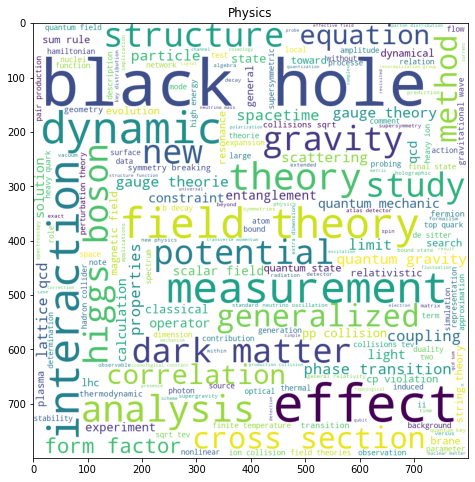

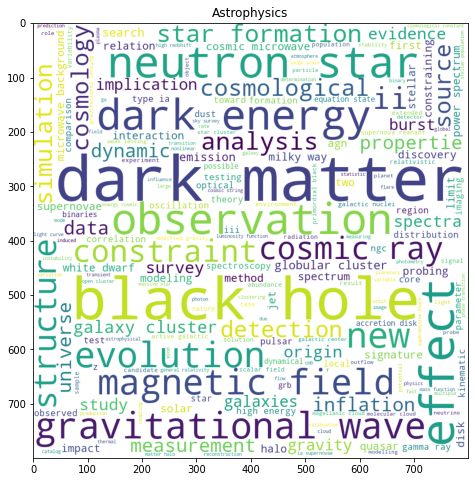

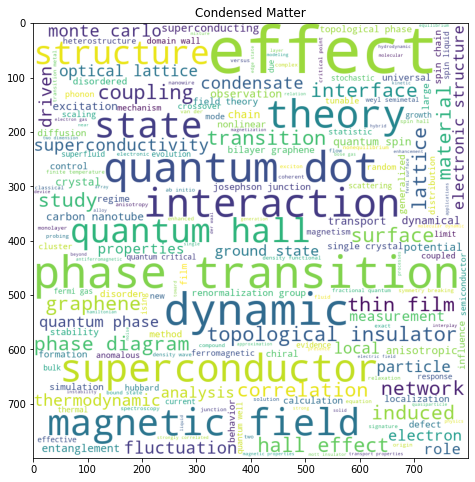

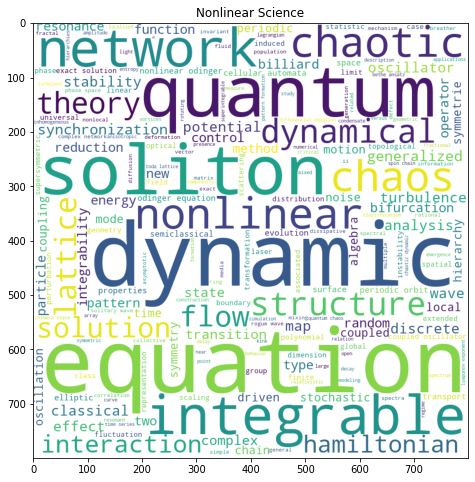

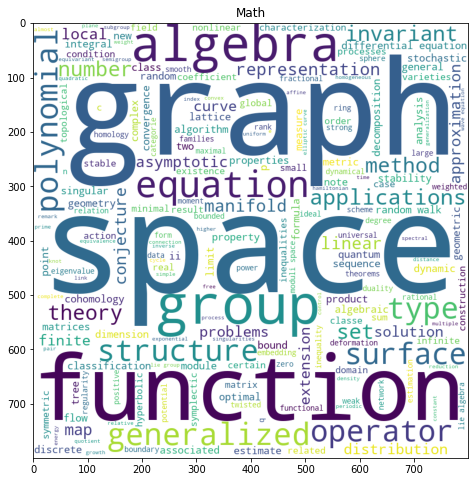

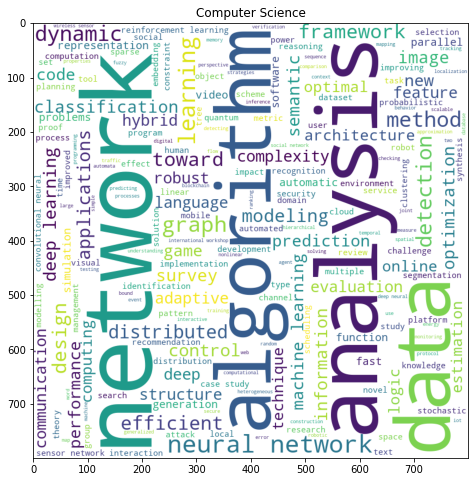

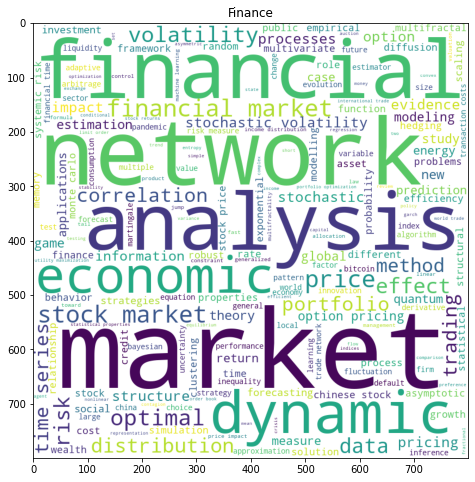

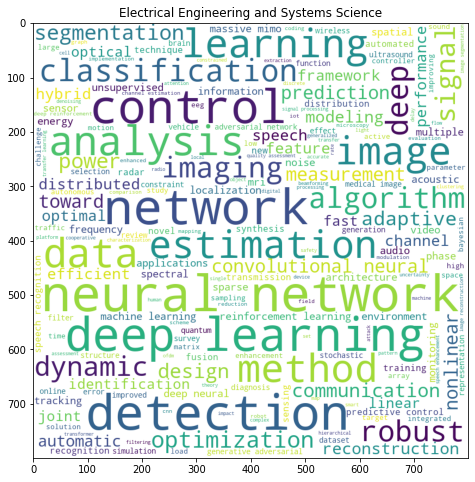

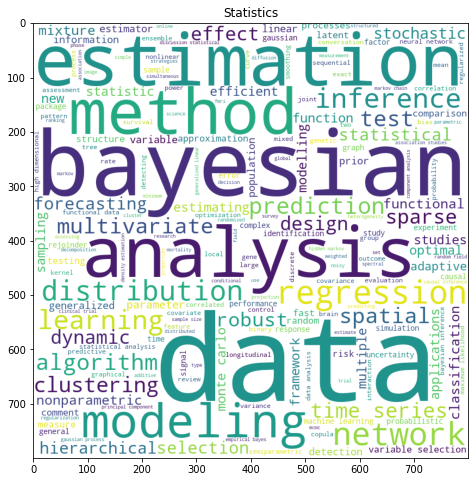

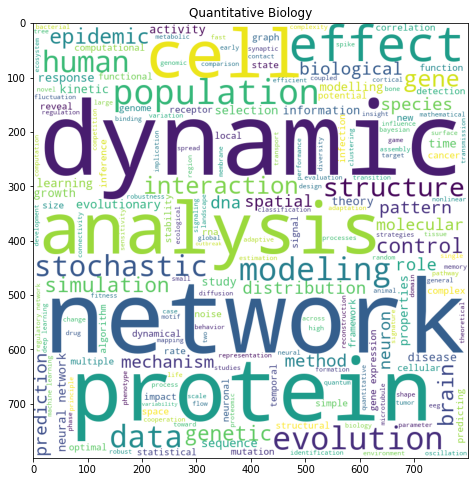

In [ ]:
for i in range(len(wc)):
  fig, ax = plt.subplots(figsize=(8,8))
  plt.imshow(wc[i].to_image())
  plt.title(order[i])
  plt.show()

#Title Prediction using SimpleT5 Model

> We chose SimpleT5 as our training model because we were looking for a model that could aid in processing blocks of texts and produce a more concise result. The example training results we have seen of SimpleT5 seemed to be the perfect fit due to its intuitive and simple structure. One problem we did not anticipate before deciding to move on with SimpleT5 was that the model does not provide a measure for accuracy. We accounted for this by incorporating the Jaccard accuracy and counting the exact matches of the actual title and the predicted summary.

1. Randomly extract the sample data from each research area
2. Train SimpleT5 model to create predicted title of research papers
3. Test and evaluate the SimpleT5 model
4. Keep the counter of generated title that exactly matches the original title
5. Use Jaccard Similarity to evaluate the accuracy of prediction by comparing the generated title with the actual titles
6. Plot the graph of Jaccard Similarity Score and Counts of exact match to the research area



> To clean the data, we removed the extra words such as ‘\n’ and ‘\s’ and renamed the columns into “source test” and “target text” to fit into the simpleT5 model.

In [ ]:
def clean_data(df):
  # reindex the dataframe
  AT_df = df.copy()
  AT_df.reset_index(inplace=True)
  AT_df.drop(columns=['index'], inplace=True)

  # clean \n characters
  AT_df['title'] = AT_df.title.apply(lambda x: x.replace("\n", " "))
  AT_df['abstract'] = AT_df.abstract.apply(lambda x: x.replace("\n", " "))

  # convert multiple spaces to 1 space
  AT_df["title"] = AT_df["title"].apply(lambda x: re.sub('\s+',' ', x))
  AT_df["abstract"] = AT_df["abstract"].apply(lambda x: re.sub('\s+',' ', x))

  # trim first and last spaces
  AT_df["abstract"] = AT_df["abstract"].apply(lambda x: x[1:-1])

  # extract abstract and title column
  AT_df = AT_df[["abstract", "title"]]

  # rename to fit simpleT5
  AT_df.columns = ["source_text", "target_text"]

  # simpleT5 expects a task related prefix. "summarize" is a good choice here
  AT_df["source_text"] = "summarize: " + AT_df["source_text"]

  return AT_df


> When modeling simpleT5, we splitted the test data set again to make a validation data set. 

In [ ]:
def train_simpleT5(train_df, test_df, name):
  # instatntiate
  model = SimpleT5()
  # load
  model.from_pretrained("t5","t5-base")
  output_dirname = "./outputs/" + name
  #train
  model.train(train_df=train_df, 
              eval_df = test_df,
              source_max_token_len=512, 
              target_max_token_len=128, 
              #dataloader_num_workers = 6,
              max_epochs=3, 
              batch_size=30,
              outputdir = output_dirname, 
              use_gpu=True,
              save_only_last_epoch=True)

> For accuracy score, we used the Jaccard Similarity method where we count the number of matching words between actual and predicted title to estimate the accuracy. 



In [ ]:
def jaccard(tru, pred):
  intersection_cardinality = len(set.intersection(*[tru, pred]))
  union_cardinality = len(set.union(*[tru, pred]))
  return intersection_cardinality/float(union_cardinality)

> When testing, we kept the counter of predicted titles that exactly matched the actual title along with the average accuracy score. Also, since a lot of academic terms were highlighted through capitalization, we lowercased all the words and compared them to measure both jaccard accuracy score and number of exact match. 


In [ ]:
def test_simpleT5(test_df, name):
  output_model = "./outputs/" + name + "/" + os.listdir("./outputs/" + name)[0]
  model = SimpleT5()
  model.load_model("t5", output_model, use_gpu=True)

  prediction = []
  exact_match = 0
  avg_score = 1.
  for i, abstract in test_df.iterrows():
    true_abstract = abstract["source_text"]
    pred_title = model.predict(true_abstract)[0]
    prediction.append(pred_title)

    true_set = set(abstract["target_text"].lower().split(" "))
    pred_set = set(pred_title.lower().split(" "))
    jaccard_score = jaccard(true_set, pred_set)
    if (jaccard_score == 1.0):
      exact_match += 1
    avg_score += jaccard_score

  avg_score /= len(test_df)

  return prediction, exact_match, avg_score

> From each category, we randomly sampled groups of 1500 papers to run in simpleT5 and aggregated them into a big sample data set. Since we will extract a test set form cate_df_list later for neural network model that will be built on top of our predicted title in this section, we filtered the papers that were included in this simpleT5 model. 

> To use the predicted titles later again and to match the label of their research area when modeling for Section 4, we stored the predicted titles separately into a list. 


In [ ]:
sample_size_simpleT5 = 1500

test_dfs_simpleT5 = [] # test dataframes for simpleT5
predictions_simpleT5 = [] #predictions for simpleT5
exact_matches_simpleT5 = [] #exact matches for simpleT5
avg_scores_simpleT5 = [] #average scores for simpleT5

In [ ]:
#Train and Test for merged data
train_df_simpleT5 = pd.DataFrame()

#Cleaning and sampling loop
for i in range(len(cate_df_list)):

  #sample and clean the data
  sample_df = clean_data(cate_df_list[i].sample(sample_size_simpleT5))

  #split the data into test and train set
  train_df, test_df = train_test_split(sample_df, test_size=0.2)
  test_dfs_simpleT5.append(test_df)

  train_df_simpleT5 = pd.concat([train_df_simpleT5, train_df])

#Train using simpletT5 model
actual_train_simpleT5, eval_simpleT5 = train_test_split(train_df_simpleT5, test_size=0.2)
train_simpleT5(actual_train_simpleT5, eval_simpleT5, "total")

#Testing loop
for i in range(len(cate_df_list)):
  pred, exact_match, avg_score = test_simpleT5(test_dfs_simpleT5[i], "total")
  predictions_simpleT5.append(pred)
  exact_matches_simpleT5.append(exact_match)
  avg_scores_simpleT5.append(avg_score)
  

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [ ]:
d = {'area': ['physics', 'astro-ph', 'cond-mat', 'nlin', 'math', 'cs', 'finance','eess', 'stat', 'qbio'], 
     'exact_match' : exact_matches_simpleT5, 'accuracy' : avg_scores_simpleT5}
score_df = pd.DataFrame(data = d)

In [ ]:
score_df

,area,exact_match,accuracy
0,physics,3,0.267972
1,astro-ph,4,0.260901
2,cond-mat,2,0.264142
3,nlin,3,0.270231
4,math,1,0.264692
5,cs,2,0.279931
6,finance,1,0.264459
7,eess,0,0.287677
8,stat,2,0.279502
9,qbio,0,0.218605


> The plotting of average accuracy score and number of exact matches for each research area and total average is as below. 

> x-axis: the count of exact matches, total average, y-axis: research category

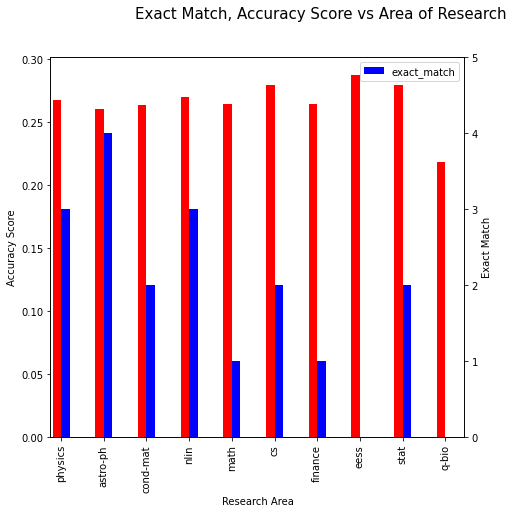

In [ ]:
fig, host = plt.subplots(figsize=(10,7))
fig.subplots_adjust(right=0.7)
guest = host.twinx()
fig.suptitle('Exact Match, Accuracy Score vs Area of Research', fontsize=15)
width = 0.2
score_df.accuracy.plot(kind='bar', color='red', ax=host, width=width, position=1)
score_df.exact_match.plot(kind='bar', color='blue', ax=guest, width=width, position=0)

host.set_xlabel("Research Area")
host.set_ylabel("Accuracy Score")
guest.set_ylabel("Exact Match")
guest.set_ylim(0, 5)

plt.xticks(range(len(cate)), cate)
plt.legend()
plt.draw()
plt.show()

In [ ]:
predictions_simpleT5[6][:10]

['Innovation activities of companies in the STAR Market Segment of the Italian Stock Exchange',
 'High-order compact finite difference schemes for option pricing in stochastic volatility models',
 'Non-stochastic reduction of continuous martingales to Brownian motion',
 'Nestedness in ecological and socio-economic networks',
 'Stock return cross-correlations and the Epps effect',
 'Ad hoc style equivalences for extensive-form games',
 'Market Fragmentation versus Consolidation',
 'Micro-econo-physics and macro-economics',
 'Clustering market states in a sparse precision matrix',
 'A generalized polynomial chaos approach to the pricing of financial derivatives']

#Research Category Prediction using Recurrent Neural Network
>1. Tokenize title data into works using nltk, build a vocabulary and embedding with gensim FastText model and nn.Embedding
2. Build a Recurrent Neural Network with 1 bidirectional LSTM layer and an FC layer with two linear layers and an ReLU activation layer.
3. Encode the input sentences using the vocabulary and pad it to match the longest sentence size

**Training**
>4. Embed the sentences using the embedding layer
5. Feed the embedded sentences through the RNN and FC layers
6. Return the last hidden state of the output
7. Compute a CrossEntropyLoss between true labels and argmax(1) of the output
8. Backpropagate loss, and iterate through batches


> We chose Recurrent Neural Network as our classifier model as natural language processing is the core element of our prediction model, especially for semantic classification analysis. Also, based on our initial assumption that there exists some significantly repetitive words or phrases in each research category, the classifier would have to capture a sequential pattern of words and their relationship for each research area. Since RNN is specialized in capturing such sequential patterns, we thought it would be the most appropriate model. 




In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from tqdm.notebook import tqdm

from gensim.models.fasttext import FastText

>We tokenized all sentences using the nltk’s word_tokenize function, ignoring stopwords and converting special characters such as “$” into tokens of “$$”, representing latex-style mathematical equations. We also encoded all fully numeric strings as token “<NUMBER>” because no numbers really have semantic meaning.  

In [ ]:
def process_content(content):
  tokens = nltk.word_tokenize(content)
  # return tokens
  result = []
  for tok in tokens:
    if tok.startswith("$"):
      result.append("$$")
      continue
    if ("-" in tok) & (len(tok) > 1):
      spt = tok.split('-')
      if len(spt) == 2:
        result.extend(spt)
      continue
    if tok.isnumeric():
      result.append("<NUMBER>")
      continue
    if tok.isalpha():
      tok = tok.lower()
      if tok not in stopwords:
        result.append(tok)
      continue
    result.append(tok)

  if len(result) == 0:
    return tokens
  return result

In [ ]:
class CategoriesDataset(Dataset):
  def __init__(self, df):
    super(CategoriesDataset, self).__init__()
    
    self.sentences, self.lens, self.categories = make_padded_sentences(df)

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    sentl = self.lens[idx] 
    return self.sentences[idx], sentl, self.categories[idx]

def make_padded_sentences(df, pad_idx=0):
  max_len = get_max_len(df.title.tolist())
  sentences, lens = pad_array(df.title.tolist(), max_len, pad_idx)
  ys = np.array(df.categories.tolist())
  return sentences, lens, ys

def pad_array(sentences, max_len, pad_id=0):
  sent_arr = np.full([len(sentences), max_len], pad_id, dtype=np.int32)
  lens = np.zeros([len(sentences)], dtype=np.int32)
  for i, sent in enumerate(sentences):
      actual_len = min(len(sent), max_len)
      sent_arr[i,:actual_len] = sent[:actual_len]
      lens[i] = actual_len
  return sent_arr, lens

def get_max_len(title_list):
  return max([len(t) for t in title_list])
  

> Our RNN included the embedding layer, a single bidirectional LSTM layer, and an FC layer that consisted of two Linear layers and one ReLU activation function. Our final linear layer in the FC layer will output the dimension of the number of categories we want to classify.

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, pretrained_weights, embedding_dropout):
        super(EmbeddingLayer, self).__init__()

        self.dropout = nn.Dropout(embedding_dropout)
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights)

    def forward(self, input):
        embedded_words = self.embedding(input)
        final_output = self.dropout(embedded_words)
        return final_output

> In training our RNN, we inputted our encoded, tokenized training sentences as input sequences to the neural network. We embedded those sequences, then fed them through our LSTM, then FC layer, eventually outputting the last hidden state of the output.

> We got the argmax of the resulting output as our “prediction” of the neural network. Since this is a classification problem, we used Cross Entropy Loss as our loss function and compared the actual categories to our predictions. We used the Adam optimizer. 



In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(nn.Module):
    def __init__(self, 
                 d_embed, 
                 d_hidden,
                 d_out, 
                 wv_weights, 
                 embedding_dropout = 0.2,
                 nl = 2,
                 batch_first = True,
                 bidirectional=True
                 ):
        super(RNN, self).__init__()

        self.d_embed = d_embed
        self.d_hidden = d_hidden
        self.d_out = d_out
        self.embedding_dropout = embedding_dropout
        self.nl = nl
        self.batch_first = batch_first
        self.bidirectional = bidirectional

        self.embedding = EmbeddingLayer(wv_weights, embedding_dropout).to(device)
        self.rnn = nn.LSTM(d_embed, d_hidden, num_layers = nl, batch_first = batch_first, bidirectional = bidirectional)
        if (bidirectional):
            lin = nn.Linear(2*d_hidden, d_hidden) ## if it's bidirectional
        else:
            lin = nn.Linear(d_hidden, d_hidden) ## if it's not bidirectional
        self.fc = nn.Sequential(
            lin,
            nn.ReLU(),
            nn.Linear(d_hidden, d_out),
        )
            
    def forward(self, x, seq_lengths):
        x = self.embedding(x).to(device)

        x = pack_padded_sequence(x, seq_lengths, batch_first = self.batch_first, enforce_sorted = False)

        x, (hn, cn) = self.rnn(x)
        x, length = pad_packed_sequence(x, batch_first = self.batch_first)
        
        x = self.fc(x)
        return x[:, -1]

In [ ]:
def transform_title(title):
  result = []
  result.extend(process_content(title))
  return result

In [ ]:
def get_index(li):
  res = []
  for tok in li:
    if tok in vocab.keys():
      res.append(vocab[tok])
      continue
    try:
      similar = emb_model.wv.most_similar(tok)[0][0]
      res.append(vocab[similar])
    except:
      res.append(0)
  return res

In [ ]:
%%time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rnn_df = pd.DataFrame()
rnn_sample_size = 2500
for df in cate_df_list:
  rnn_df = pd.concat([rnn_df, df.sample(2500)])

rnn_df['title'] = rnn_df['title'].apply(lambda x: x.replace("\n", " "))
rnn_df = rnn_df[['categories', 'title']].reset_index()

train_rnn, test_rnn = train_test_split(rnn_df, test_size=0.2)

#category dictionary
idx_to_cate = dict(enumerate(train_rnn.categories.unique()))
cate_to_idx = dict((j, i) for i, j in idx_to_cate.items())
#encode features
train_rnn['categories'] = train_rnn['categories'].apply(lambda x: cate_to_idx[x])

#tokenize and pad titles
train_rnn['title'] = train_rnn['title'].apply(lambda x: transform_title(x))

CPU times: user 2.28 s, sys: 3.94 ms, total: 2.28 s
Wall time: 2.28 s


>We inputted all the tokenized training sentences through the gensim’s FastText model, returning us the embedding vectors and the vocabulary that mapped each tokenized word in the sentence to an integer. Using the vocabulary dictionary, we converted each tokenized sentence into a list of integers.

In [ ]:
%%time
d_embed = 300
#fasttext embeddings of titles
emb_model = FastText(train_rnn['title'].tolist(), size=d_embed, min_count=0, iter=20)
idx2word = dict(enumerate(emb_model.wv.vocab))
vocab = dict((j,i) for i,j in idx2word.items())
train_rnn['title'] = train_rnn['title'].apply(lambda x: get_index(x))

CPU times: user 1min 3s, sys: 185 ms, total: 1min 4s
Wall time: 28.5 s


In [ ]:
%%time
batch_size = 64
trainset = CategoriesDataset(train_rnn)
train_iter = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)

CPU times: user 39.1 ms, sys: 0 ns, total: 39.1 ms
Wall time: 38.1 ms


In [ ]:
d_hidden = 300
d_out = len(cate_to_idx)
embedding_dropout = 0.1
nl = 5
batch_first = True
bidirectional = True
rnn = RNN(d_embed, 
          d_hidden,
          d_out, 
          torch.FloatTensor(emb_model.wv.vectors).to(device), 
          embedding_dropout, 
          nl, 
          batch_first,
          bidirectional).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(rnn.parameters(), lr=0.001) #lr - learning step
epoch = 25

acc_LIST = []
loss_LIST = []

In [ ]:
%%time
for t in tqdm(range(0, epoch)):
  running_loss = 0.0
  correct = 0
  total = 0
  verbose = True
  for batch_idx, batch in enumerate(train_iter):
    optimizer.zero_grad()

    title, lens, label = batch
    title = title.to(device)
    label = label.to(device)

    outputs = rnn(title, lens)

    _, predicted = torch.max(outputs.data, 1)
    total += batch_size
    correct += (predicted == label).sum().item()

    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  accuracy = 100 * correct / total # Calculate Trining Acc
  acc_LIST.append(accuracy)
  loss_LIST.append(running_loss / len(train_rnn)) # get the avg loss for each epoch
  
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(t, running_loss/len(train_rnn), accuracy))

  0%|          | 0/25 [00:00<?, ?it/s]

The loss for Epoch 0 is: 0.03479491100311279, Accuracy = 9.919129392971247
The loss for Epoch 1 is: 0.03440292954444885, Accuracy = 10.208666134185304
The loss for Epoch 2 is: 0.03437848800420761, Accuracy = 10.313498402555911
The loss for Epoch 3 is: 0.034375877463817595, Accuracy = 10.637979233226837
The loss for Epoch 4 is: 0.03437153913974762, Accuracy = 10.448282747603834
The loss for Epoch 5 is: 0.03436844530105591, Accuracy = 10.333466453674122
The loss for Epoch 6 is: 0.0343713852763176, Accuracy = 10.40335463258786
The loss for Epoch 7 is: 0.034379884111881254, Accuracy = 9.59464856230032
The loss for Epoch 8 is: 0.03435641424655914, Accuracy = 9.859225239616613
The loss for Epoch 9 is: 0.03435109397172928, Accuracy = 10.298522364217252
The loss for Epoch 10 is: 0.03437059648036957, Accuracy = 10.07388178913738
The loss for Epoch 11 is: 0.034368845307826995, Accuracy = 9.759384984025559
The loss for Epoch 12 is: 0.034370072150230406, Accuracy = 10.048921725239616
The loss for 

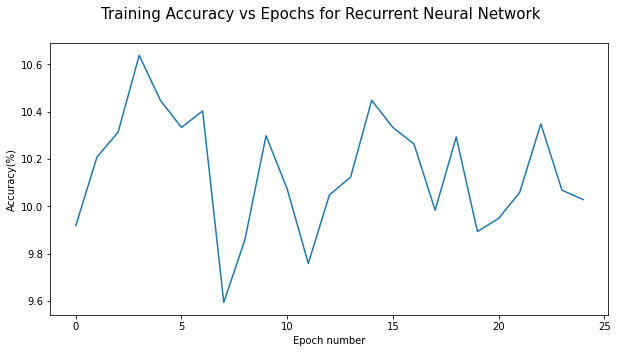

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Training Accuracy vs Epochs for Recurrent Neural Network', fontsize=15)
fig = sns.lineplot(x=range(25), y=acc_LIST)
plt.xlabel("Epoch number")
plt.ylabel("Accuracy(%)")
plt.show()

>We tested the trained RNN model to 2 different data sets – one from the cleaned original titles and the other from the predicted results from the SimpleT5 Model we used in the previous section. 

**Cleaned Original Dataset**

In [ ]:
%%time
test_rnn['title'] = test_rnn['title'].apply(lambda x: x.replace("\n", " "))

#encode features
test_rnn['categories'] = test_rnn['categories'].apply(lambda x: cate_to_idx[x])

#tokenize and pad titles
test_rnn['title'] = test_rnn['title'].apply(lambda x: transform_title(x))


CPU times: user 558 ms, sys: 1.03 ms, total: 559 ms
Wall time: 557 ms


In [ ]:
test_rnn['title'] = test_rnn['title'].apply(lambda x: get_index(x))

In [ ]:
testset = CategoriesDataset(test_rnn)
test_iter = DataLoader(testset, batch_size, shuffle=True, num_workers=0)

In [ ]:
%%time
total = 0
correct = 0
for batch_idx, batch in enumerate(test_iter):
  title, lens, label = batch
  title = title.to(device)
  label = label.to(device)

  outputs = rnn(title, lens)

  _, predicted = torch.max(outputs.data, 1)
  total += batch_size
  correct += (predicted == label).sum().item()

test_acc = 100 * correct / total

print(f'Test Accuracy: ' + str(test_acc))

Test Accuracy: 10.087025316455696
CPU times: user 456 ms, sys: 1.06 ms, total: 457 ms
Wall time: 453 ms


**Predicted Title Dataset from SimpleT5 Model**

In [ ]:
dff = pd.DataFrame(columns=['title', 'categories'])
for i in range(len(predictions_simpleT5)):
  cate_list = [cate[i]] * len(predictions_simpleT5[i])
  temp = pd.DataFrame(list(zip(predictions_simpleT5[i], cate_list)), columns=['title', 'categories'])
  dff = pd.concat([dff, temp])
dff

,title,categories
0,Chiral suppression of domain-wall fermions by ...,physics
1,Optimal in vivo PET imager for small plants,physics
2,Pre-Compensation for Quantum Key Distribution,physics
3,The Stueckelberg trick and the high-energy lim...,physics
4,Rotation-invariant polarization and decay pari...,physics
...,...,...
295,Learning-to-Rank in ligand-based virtual scree...,q-bio
296,The organization and mining of malaria genomic...,q-bio
297,Pre-assembly and error correction in functiona...,q-bio
298,Synchronous update and polarized groups in sel...,q-bio


In [ ]:
dff['title'] = dff['title'].apply(lambda x: x.replace("\n", " "))

#encode features
dff['categories'] = dff['categories'].apply(lambda x: cate_to_idx[x])

#tokenize and pad titles
dff['title'] = dff['title'].apply(lambda x: transform_title(x))
dff['title'] = dff['title'].apply(lambda x: get_index(x))

pred_test_set = CategoriesDataset(dff)
pred_test_iter = DataLoader(pred_test_set, batch_size, shuffle=True, num_workers=0)

In [ ]:
%%time
total = 0
correct = 0
for batch_idx, batch in enumerate(pred_test_iter):
  title, lens, label = batch
  title = title.to(device)
  label = label.to(device)

  outputs = rnn(title, lens)

  _, predicted = torch.max(outputs.data, 1)
  total += batch_size
  correct += (predicted == label).sum().item()

test_acc = 100 * correct / total

print(f'Test Accuracy: ' + str(test_acc))

Test Accuracy: 10.106382978723405
CPU times: user 233 ms, sys: 71 µs, total: 234 ms
Wall time: 231 ms


#Putting it all together...
> We will perform a cycle of data analysis and modeling of Section 3 and 4 using randomly sampled data

**Random Sampling of Data**

In [ ]:
#given abstract of a random sample of articles,
sample_df = pd.DataFrame()
for df in cate_df_list:
  sample_df = pd.concat([sample_df, df.sample(10)])
sample_df = sample_df[['categories', 'title', 'abstract']]
sample_df

,categories,title,abstract
224824,physics,On the finiteness of noncommutative supersymme...,The three-dimensional noncommutative supersy...
197463,physics,Exclusive (B -> rho l^+ l^-) decay and Polariz...,The polarized lepton pair forward-backward a...
170424,physics,On smoothness-asymmetric null infinities,We discuss the existence of asymptotically E...
163659,physics,Experimental analysis and transient numerical ...,A multi-parametric transient numerical simul...
215898,physics,"Theta Vacua, QCD Sum Rules, and the Neutron El...",We present a detailed study of the electric ...
...,...,...,...
1789,q-bio,"On Eigen's quasispecies model, two-valued fitn...",A two-valued fitness landscape is introduced...
3828,q-bio,Poacher-population dynamics when legal trade o...,"Can a regulated, legal market for wildlife p..."
3944,q-bio,An infectious diseases hazard map for India ba...,We propose a risk measure and construct an i...
2002,q-bio,Adaptability of non-genetic diversity in bacte...,Bacterial chemotaxis systems are as diverse ...


**Generating predicted title using SimpleT5 Model**

In [ ]:
#We can get the predicted titles,
cleaned_sample_df = clean_data(sample_df)
pred, exact, avg = test_simpleT5(cleaned_sample_df, "total")
pred

['The superfield approach to the three-dimensional supersymmetric QED',
 'The polarized lepton pair forward-backward asymmetries in decay',
 'Null infinity of the Schwarzschild black hole',
 'Multi-parametric simulation of the start-up of a large diameter Pulsating Heat Pipe in microgravity',
 'Electric dipole moment of the neutron in a vacuum theta angle',
 'Quantum Weiss-Weinstein bounds',
 'Grassmann integration and Lorentz trace of one-gluon loop diagrams',
 'Quantum parameter estimation with adaptive and non-adaptive quantum smoothing',
 'Collisions at $sqrts__NN=200$ GeV with Collective Effects',
 'Bekenstein-Hawking entropy of an evaporating black hole',
 'Loop quantum cosmology and its application to homogeneous systems',
 'Dipper stars in Taurus',
 'Multi-messenger observations of neutron star mergers',
 'Ly-alpha emission at z  1 in radio galaxies',
 'Constraints on the amplitude and spectral index of primordial magnetic fields',
 'Radio-interferometric observations of HCN J=

**Link the Predicted Title back to its category classified in Section 1**

In [ ]:
# And using this, get back their predicted categories
cate_list = []
for i in range(len(cate)):
  cate_list.extend([cate[i]] * 10)

rnn_dff = pd.DataFrame(list(zip(pred, cate_list)), columns=['title', 'categories'])

rnn_dff['title'] = rnn_dff['title'].apply(lambda x: x.replace("\n", " "))

#encode features
rnn_dff['categories'] = rnn_dff['categories'].apply(lambda x: cate_to_idx[x])

#tokenize and pad titles
rnn_dff['title'] = rnn_dff['title'].apply(lambda x: transform_title(x))
rnn_dff['title'] = rnn_dff['title'].apply(lambda x: get_index(x))

sample_test_set = CategoriesDataset(rnn_dff)
sample_test_iter = DataLoader(sample_test_set, 10, shuffle=False, num_workers=0)

**RNN Model testing with Randomly Sampled Data**

In [ ]:
#This is our entire framework!
%%time
total = 0
correct = 0
for batch_idx, batch in enumerate(sample_test_iter):
  title, lens, label = batch
  title = title.to(device)
  label = label.to(device)

  outputs = rnn(title, lens)

  _, predicted = torch.max(outputs.data, 1)
  total += 10
  correct += (predicted == label).sum().item()

test_acc = 100 * correct / total

print(f'Test Accuracy: ' + str(test_acc))

Test Accuracy: 10.0
CPU times: user 41.4 ms, sys: 985 µs, total: 42.3 ms
Wall time: 41.6 ms


#Wrapping up..and how to be better

>Another challenge was the imbalance in our data size. Majority of our articles were categorized as physics even after we used a lenient standard for the categories that showed relatively weak representations. The difference in aggregated number of articles per category was huge, to the point where one category - “physics” - had more than 20000 articles while “finance” only had around 2500 articles. Hence the overall size of the dataset became limited as we wanted to input the same number of articles per research area for the train data to avoid the inherent bias in the data set. This may be the reason why our model is underfitting: Neural Network models typically need large datasets when there is huge gap that could not be resolved with oversampling, which similarly applies to SimpleT5 Model. 

>One thing we were able to find out when adjusting the RNN model was that there is lack of repeating patterns of word. Even after tuning various hyperparameters(for example, adding more layers, changing the parameters), the accuracy and loss showed a very subtle difference. Even in cases when we oversampled the data and increased the overall size of train data, it was hard to find any significant pattern. Most of the word patterns were unique and had low frequency where there was barely any “pattern”  in words specific for each research category. 

>A conjecture we have for the low accuracy is that because of the intersectional nature of academic papers. In the earlier stages of the project, we have noticed that many of the papers were categorized as multiple academic areas. For example, there were many papers with ‘Physics’, ‘Math’, and ‘Computer Science’ as their category. For STEM fields, it seemed to be difficult for a research paper to fall into one specific area. Furthermore, looking at the wordcloud that we created, while there were some significant words that appeared in each research area, the overwhelming majority consisted of overlapping common words. This pattern was more distinct among the larger subset of academic fields; the words found in the wordclouds of Mathematics, Physics, Computer science, and Electrical Engineering and Systems Science had similar nuances, but differed from the words in Finance, or the Statistics and Quantitative fields groups. The fine lines between each of our categorized research areas were not distinct enough to be captured into a noticeable pattern. 

>Although not perfect, through our rigorous trial-and-error process, we have learned many valuable lessons on real-life applications of Data Science and its implications. From the beginning phases where we were faced with lack of resource issues caused by handling huge volumes of data to attempting to implement our own neural network, we have experienced first-hand the materials we have learned throughout the course. If we get to do a similar project in the future, we would try to amend our initial hypothesis as we progress, try out different classifier models and maybe create a more efficient neural network.

